# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [ ]:
# Check for GPU
!nvidia-smi

Sat Jun  8 13:59:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              27W /  70W |    181MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.0+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Add more layers/units to your model If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers.
2. Tweak the learning rate : Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything, hence lowering lr helps
3. Use transfer learning: It involves using the patterns from a previously working model and adjusting them to your own problem, therefore avoids issues of a small dataset

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [ ]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

#setting path to data folder
data_path = Path("data/")
image_path = data_path/"pizz_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents = True, exist_ok = True)

  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

    # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)


data/pizz_steak_sushi directory exists


In [ ]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizz_steak_sushi'.
There are 3 directories and 0 images in 'data/pizz_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizz_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizz_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizz_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizz_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizz_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizz_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizz_steak_sushi/train/pizza'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir


(PosixPath('data/pizz_steak_sushi/train'),
 PosixPath('data/pizz_steak_sushi/test'))

Random image path: data/pizz_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


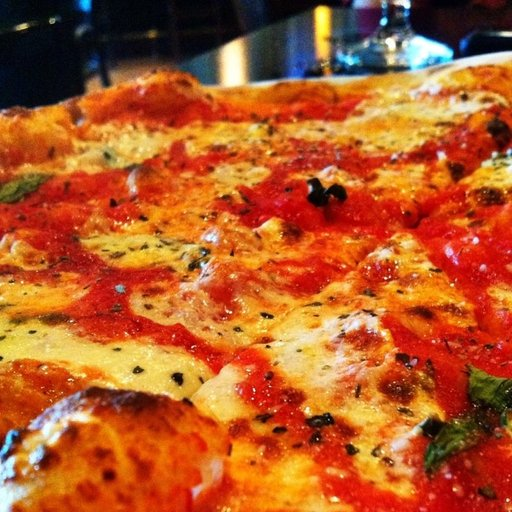

In [ ]:
# Visualize an image
import random
from PIL import Image

random.seed(42)  #random seed for random module not Pytorch
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)


print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

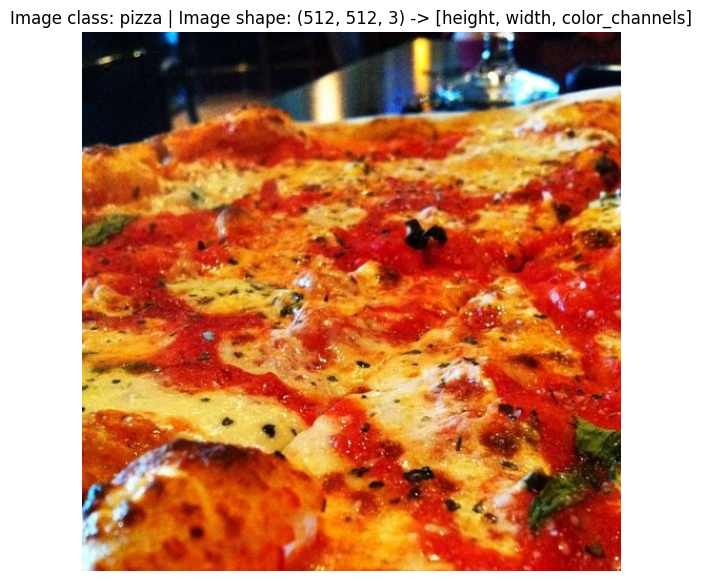

In [ ]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turning the image into an array
img_as_array = np.asarray(img)

# Plotting the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [ ]:
# 3.1 Transforming data with torchvision.transforms
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

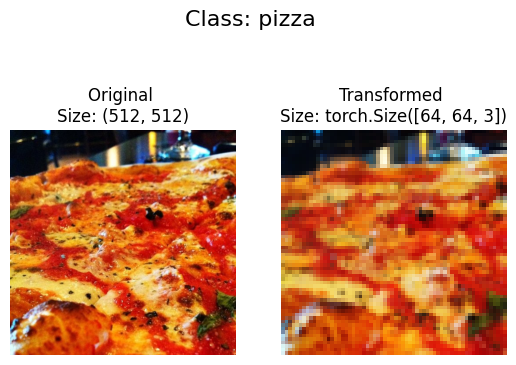

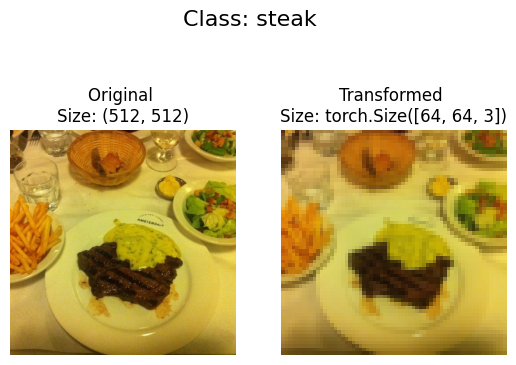

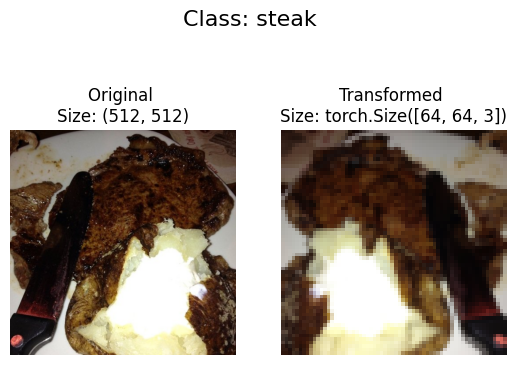

In [ ]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

### Load image data using `ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizz_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizz_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b2deb660340>,
 <torch.utils.data.dataloader.DataLoader at 0x7b2e020ae530>)

In [ ]:
# How many batches of images are in our data loaders?
import math
batch_size = 1

num_batches = math.ceil( len(train_data)/ batch_size)

print(f"Number of batches in train : {num_batches}")



num_batches_test = math.ceil( len(test_data)/ batch_size)

print(f"Number of batches in test : {num_batches_test}")



num_batches, num_batches_test


Number of batches in train : 225
Number of batches in test : 75


(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):

        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send data to target device
    X,y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()


    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)




  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model= model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1184 | train_acc: 0.2978 | test_loss: 1.0970 | test_acc: 0.4133
Epoch: 2 | train_loss: 1.1002 | train_acc: 0.2933 | test_loss: 1.0994 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0993 | train_acc: 0.3067 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.1038 | train_acc: 0.3422 | test_loss: 1.1005 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0991 | train_acc: 0.2933 | test_loss: 1.1008 | test_acc: 0.3333
Total training time: 11.352 seconds


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [ ]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)
# Set number of epochs
NUM_EPOCHS = 5


# Train model_0
model_0_results = train(model= model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0993 | train_acc: 0.2978 | test_loss: 1.1001 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1003 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.1056 | train_acc: 0.3467 | test_loss: 1.0966 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0846 | train_acc: 0.4356 | test_loss: 1.0383 | test_acc: 0.5067
Epoch: 5 | train_loss: 0.9591 | train_acc: 0.5600 | test_loss: 0.9860 | test_acc: 0.4933


In [ ]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)
NUM_EPOCHS = 20


# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model= model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8647 | train_acc: 0.6400 | test_loss: 1.0299 | test_acc: 0.4933
Epoch: 2 | train_loss: 0.8105 | train_acc: 0.6222 | test_loss: 1.1064 | test_acc: 0.4267
Epoch: 3 | train_loss: 0.7822 | train_acc: 0.6400 | test_loss: 1.0370 | test_acc: 0.4800
Epoch: 4 | train_loss: 0.7443 | train_acc: 0.6667 | test_loss: 1.0503 | test_acc: 0.4267
Epoch: 5 | train_loss: 0.6537 | train_acc: 0.7111 | test_loss: 1.1011 | test_acc: 0.4800
Epoch: 6 | train_loss: 0.6076 | train_acc: 0.7556 | test_loss: 1.2427 | test_acc: 0.4667
Epoch: 7 | train_loss: 0.5034 | train_acc: 0.7778 | test_loss: 1.4557 | test_acc: 0.4133
Epoch: 8 | train_loss: 0.4415 | train_acc: 0.8356 | test_loss: 1.4581 | test_acc: 0.4133
Epoch: 9 | train_loss: 0.3612 | train_acc: 0.8889 | test_loss: 1.6840 | test_acc: 0.4667
Epoch: 10 | train_loss: 0.2632 | train_acc: 0.9111 | test_loss: 2.1234 | test_acc: 0.3600
Epoch: 11 | train_loss: 0.2398 | train_acc: 0.9111 | test_loss: 2.3281 | test_acc: 0.4533
Epoch: 12 | train_l

In [ ]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)


NUM_EPOCHS = 50


# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model= model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5836 | train_acc: 0.7467 | test_loss: 1.7674 | test_acc: 0.4400
Epoch: 2 | train_loss: 0.5305 | train_acc: 0.7778 | test_loss: 1.5799 | test_acc: 0.4533
Epoch: 3 | train_loss: 0.4883 | train_acc: 0.7911 | test_loss: 1.7835 | test_acc: 0.4000
Epoch: 4 | train_loss: 0.3733 | train_acc: 0.8667 | test_loss: 1.7277 | test_acc: 0.4133
Epoch: 5 | train_loss: 0.2827 | train_acc: 0.9022 | test_loss: 2.2611 | test_acc: 0.4000
Epoch: 6 | train_loss: 0.2381 | train_acc: 0.9067 | test_loss: 2.3893 | test_acc: 0.4133
Epoch: 7 | train_loss: 0.1822 | train_acc: 0.9333 | test_loss: 3.5800 | test_acc: 0.3467
Epoch: 8 | train_loss: 0.1093 | train_acc: 0.9733 | test_loss: 4.1858 | test_acc: 0.3867
Epoch: 9 | train_loss: 0.0620 | train_acc: 0.9822 | test_loss: 4.1370 | test_acc: 0.3867
Epoch: 10 | train_loss: 0.0348 | train_acc: 0.9911 | test_loss: 5.6103 | test_acc: 0.4267
Epoch: 11 | train_loss: 0.0227 | train_acc: 0.9956 | test_loss: 5.4816 | test_acc: 0.4133
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model= model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0960 | train_acc: 0.3867 | test_loss: 1.0614 | test_acc: 0.3867
Epoch: 2 | train_loss: 1.0018 | train_acc: 0.5600 | test_loss: 1.0350 | test_acc: 0.4000
Epoch: 3 | train_loss: 0.9138 | train_acc: 0.5956 | test_loss: 0.9732 | test_acc: 0.4667
Epoch: 4 | train_loss: 0.8535 | train_acc: 0.6356 | test_loss: 1.0056 | test_acc: 0.4800
Epoch: 5 | train_loss: 0.7994 | train_acc: 0.6444 | test_loss: 1.0512 | test_acc: 0.4533
Epoch: 6 | train_loss: 0.7839 | train_acc: 0.6533 | test_loss: 1.0815 | test_acc: 0.4400
Epoch: 7 | train_loss: 0.7316 | train_acc: 0.6756 | test_loss: 1.2018 | test_acc: 0.4667
Epoch: 8 | train_loss: 0.6021 | train_acc: 0.7644 | test_loss: 1.2233 | test_acc: 0.4533
Epoch: 9 | train_loss: 0.5181 | train_acc: 0.7689 | test_loss: 1.3495 | test_acc: 0.3867
Epoch: 10 | train_loss: 0.4421 | train_acc: 0.7778 | test_loss: 2.0147 | test_acc: 0.4400
Epoch: 11 | train_loss: 0.3700 | train_acc: 0.8667 | test_loss: 1.8135 | test_acc: 0.4933
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [ ]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizz_steak_sushi'.
There are 3 directories and 0 images in 'data/pizz_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizz_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizz_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizz_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizz_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizz_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizz_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizz_steak_sushi/train/pizza'.


Excellent, we now have double the training and testing images...

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizz_steak_sushi/train'),
 PosixPath('data/pizz_steak_sushi/test'))

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor()
])

# Create datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=simple_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform)

# Create dataloaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model= model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1001 | train_acc: 0.3556 | test_loss: 1.0829 | test_acc: 0.3467
Epoch: 2 | train_loss: 1.0362 | train_acc: 0.4444 | test_loss: 1.0022 | test_acc: 0.4800
Epoch: 3 | train_loss: 0.9624 | train_acc: 0.5556 | test_loss: 0.9828 | test_acc: 0.4267
Epoch: 4 | train_loss: 0.9124 | train_acc: 0.5911 | test_loss: 1.0586 | test_acc: 0.4800
Epoch: 5 | train_loss: 0.9068 | train_acc: 0.5867 | test_loss: 1.0067 | test_acc: 0.3733
Epoch: 6 | train_loss: 0.8535 | train_acc: 0.6311 | test_loss: 0.9559 | test_acc: 0.5333
Epoch: 7 | train_loss: 0.8510 | train_acc: 0.6444 | test_loss: 1.0187 | test_acc: 0.4667
Epoch: 8 | train_loss: 0.7943 | train_acc: 0.6489 | test_loss: 1.0051 | test_acc: 0.4400
Epoch: 9 | train_loss: 0.7449 | train_acc: 0.6622 | test_loss: 1.0246 | test_acc: 0.4133
Epoch: 10 | train_loss: 0.7281 | train_acc: 0.6711 | test_loss: 1.0520 | test_acc: 0.4000
Epoch: 11 | train_loss: 0.7481 | train_acc: 0.6444 | test_loss: 1.0108 | test_acc: 0.4400
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [ ]:
import torchvision

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "new_pizza.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://theawesomedaily.com/wp-content/uploads/2016/09/pictures-of-pizza-23-1.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [ ]:
from typing import List


In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    target_image = target_image / 255.


    if transform:
        target_image = transform(target_image)

    model.to(device)


    model.eval()
    with torch.inference_mode():

        target_image = target_image.unsqueeze(dim=0)


        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

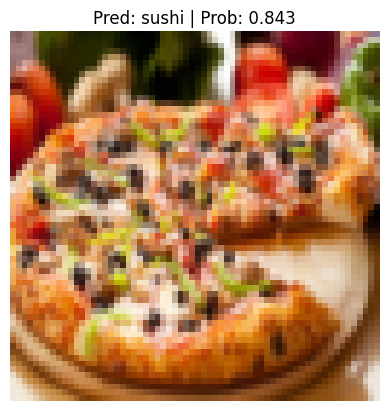

In [ ]:
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

I will use data augmentation, increase the data, increase the number of layers.